In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
from sklearn.cluster import KMeans

def custom_grouping(index):
    return index // 1000

def distribute_payload(r):
  duration=r['duration']
  start=int(r['submission_time'])
  payload=4096
  per_unit_time=payload/max(duration,1.)
  residue=payload-per_unit_time*math.floor(duration)
  return pd.DataFrame([{'payload': a, 'submission_time':b}
                       for a,b in zip([per_unit_time]*math.floor(duration)+([residue] if residue>0. else []),
                                      range(start, start+math.ceil(duration), 1))])


In [2]:
names_latency=['submission_time', 'duration', 'op2', 'write_size', 'op3']
columns = ['submission_time', 'duration', 'write_size']

# Step 1: Read the CSV file into a Pandas DataFrame
#df = pd.read_csv('/home/surbhi/measurements/worst_case/STL/4K/90-10-LBA/90Util/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df = pd.read_csv('/home/surbhi/measurements/worst_case/lsdm/4K/90-10-LBA/90Util/lat_log_avg_lat.1.log', names=names_latency, usecols=columns)
df['submission_time'] = df['submission_time'] - df.iloc[0].submission_time
df['duration'] = df['duration'] / 1e6

In [3]:
df2=pd.concat(df.apply(distribute_payload, axis=1).tolist(), ignore_index=True)

In [4]:
df3=df2.groupby('submission_time').agg({'payload': 'sum'}).reset_index()

In [12]:
assert math.ceil(df2.payload.sum()) == len(df)*4096
assert math.ceil(df3.payload.sum()) == len(df)*4096
print(math.ceil(df2.payload.sum()))
print(math.ceil(df3.payload.sum()))
print(len(df) * 4096)

5368709120
5368709120
5368709120


In [16]:
chunk_size = 10000
results = []
for i in range(0, len(df3), chunk_size):
    chunk = df3.iloc[i:i+chunk_size]
    result = chunk.groupby(custom_grouping).sum()
    results.append(result)

df_grouped = pd.concat(results)

# Reset the index to make it a regular column
df_grouped.reset_index(inplace=True)
df_grouped['cumulative_gb'] = df_grouped['payload'].cumsum() / (1024 ** 3)
df_grouped['payload'] = df_grouped['payload'] / (1024 ** 2) 
#
#data_array = df_grouped['data_written_bytes'].values.reshape(-1, 1)
print(df_grouped.describe())
print(df_grouped.info())

             index  submission_time      payload  cumulative_gb
count  1621.000000     1.621000e+03  1621.000000    1621.000000
mean    810.000000     9.042349e+08     3.158544       2.601127
std     468.086708     5.636205e+08    14.366435       1.351863
min       0.000000     5.371470e+05     0.000054       0.009595
25%     405.000000     4.286325e+08     0.047148       2.284211
50%     810.000000     8.354715e+08     0.047794       2.303010
75%    1215.000000     1.366780e+09     0.048857       3.563675
max    1620.000000     1.938874e+09   190.961207       5.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1621 entries, 0 to 1620
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            1621 non-null   int64  
 1   submission_time  1621 non-null   int64  
 2   payload          1621 non-null   float64
 3   cumulative_gb    1621 non-null   float64
dtypes: float64(2), int64(2)
memory usage:

In [17]:
data_array = df_grouped['payload'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_array)
# Get the cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()
# Sort cluster centers to get the lowest and highest modes
cluster_centers.sort()
# Calculate the average of each mode
average_mode1 = cluster_centers[0]
average_mode2 = cluster_centers[1]
print("Average1: " + str(round(average_mode1, )))
print("Average2: " + str(round(average_mode2, )))
avg_bw_str1 = str(round(average_mode1, 2)) + 'MB/sec'
avg_bw_str2 = str(round(average_mode2, 2)) + 'MB/sec'

Average1: 2
Average2: 184


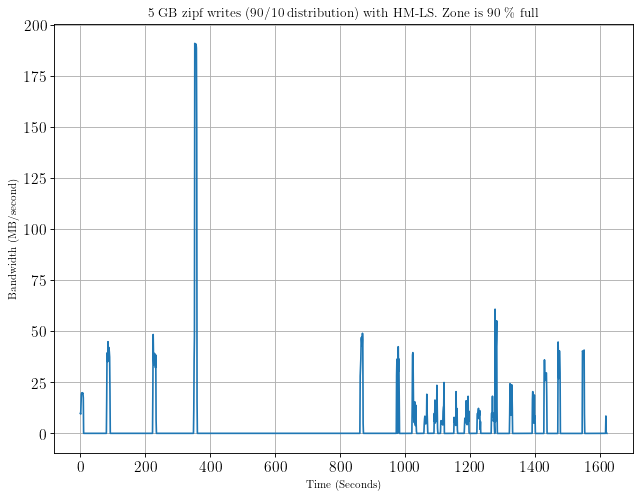

In [18]:
# Plot vertical lines at x where y is higher than the threshold
# Plot the data size over time for each resolution
plt.figure(figsize=(8, 6), dpi=80)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0, 100000)
#plt.ylim(0, 250)
plt.tight_layout()
plt.plot(df_grouped.index, df_grouped['payload'])
#plt.plot(df_grouped['cumulative_gb'], df_grouped['data_written_bytes'])
plt.xlabel('Time (Seconds)')
plt.ylabel('Bandwidth (MB/second)')
#plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
#plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)
#plt.legend(loc='center right', fontsize=14)
plt.grid(True)  # Optionally, add grid lines
plt.title("5 GB zipf writes (90/10 distribution) with HM-LS. Zone is 90 \% full")
plt.savefig('/home/surbhi/github/surbhi-plots/new/LSDM/4K_90Util_LSDM_BW.png', bbox_inches='tight')
plt.show()


In [19]:
plt.plot(df_grouped['cumulative_gb'], df_grouped['payload'])
plt.xlabel('Cumulative GBs written')
plt.ylabel('Bandwidth (MB/second)')
plt.axhline(y=average_mode2, color='g', linestyle='-', label='Avg Higher Bandwidth: ' + avg_bw_str2)
plt.axhline(y=average_mode1, color='r', linestyle='-', label='Avg Lower Bandwidth: ' + avg_bw_str1)
plt.legend(loc='center right', fontsize=14)
plt.grid(True)  # Optionally, add grid lines
plt.title("5 GB zipf writes (90/10 distribution) with DM-Hybrid. Zone is 90 \% full")
plt.savefig('/home/surbhi/github/surbhi-plots/new/STL/4K_90Util_STL_CGB_BW.png', bbox_inches='tight')
plt.show()

KeyError: 'data_written_bytes'